### Web scrapping. Load table from website. NOTE: Clean data is loaded later in case website is no longer available.

### Team Name

In [1]:
team_name = 'Kings'

In [2]:
#https://www.coursera.org/learn/python-plotting/discussions/weeks/4/threads/yMT7zw2KEeeqzRJFs29uDA

import pandas as pd
from IPython.display import display, HTML


def install_module(module):
    ! conda install "$module" -y
    js_cmd = ['IPython.notebook.kernel.restart();',
              'IPython.notebook.select(1);',
              'IPython.notebook.execute_cell();'
              ]
    js = "<script>{0}</script>".format(' '.join(js_cmd))
    display(HTML(js))

#url = 'https://simple.wikipedia.org/wiki/List_of_U.S._states'
url = 'https://en.wikipedia.org/wiki/List_of_Los_Angeles_Kings_seasons'
try:
    df_list = pd.read_html(url)
except Exception as e:
    print(e)
    # #install necessary modules for read_html
    module = str(e).split()[0]
    install_module(module)
print('Number of Data Frames {}'.format(len(df_list)))
df_list[0].columns = df_list[0].iloc[0]
df = df_list[0].iloc[1:]
df.head()

Number of Data Frames 7


,Season,Team,GP,W,L,T,OTL,Pts,GF,GA,PIM,Finish,Playoffs
1,1967–68,1967–68,74,31,33,10,--,72,200,224,810,2nd in West,"Lost in Quarterfinals, 3–4 (North Stars)"
2,1968–69,1968–69,76,24,42,10,--,58,185,260,698,4th in West,"Won in Quarterfinals, 4–3 (Seals) Lost in Semi..."
3,1969–70,1969–70,76,14,52,10,--,38,168,290,969,6th in West,Did not qualify
4,1970–71,1970–71,78,25,40,13,--,63,239,303,775,5th in West,Did not qualify
5,1971–72,1971–72,78,20,49,9,--,49,206,305,719,7th in West,Did not qualify


### Multiple tables found. Capture them all in a list of dataframes.

In [3]:
# https://stackoverflow.com/questions/42225204/use-pandas-to-get-multiple-tables-from-webpage

import urllib
from bs4 import BeautifulSoup
url = 'https://en.wikipedia.org/wiki/List_of_Los_Angeles_Kings_seasons'
html_table = urllib.request.urlopen(url).read()

# fix HTML
soup = BeautifulSoup(html_table, "html.parser")
# warn! id ratings-table is your page specific
for table in soup.findChildren(attrs={'id': 'ratings-table'}): 
    for c in table.children:
        if c.name in ['tbody', 'thead']:
            c.unwrap()

list_df = pd.read_html(str(soup), flavor="bs4")
len(list_df[0])

55

### This is the table we are interested it.

In [4]:
#list_df[2][15:].head()
#list_df[0].head()
#list_df[0].tail(10)
df_kings = list_df[0]

### Save raw data .csv

In [5]:
file_name = team_name +'_data_raw'

#csv
df_kings.to_csv( file_name +'.csv')

### Clean the data. Make the first row the header for the columns.

In [6]:
# Make the first row the header column
# NOTE: This does not get rid of the row.
df_kings.columns = df_kings.iloc[0]

# Re-index and drop the first row.
df_kings_cleaned = df_kings.reindex(df_kings.index.drop(0))

# Keep the rows we want (i.e. the years they became the team for the city.)
df_kings_cleaned = df_kings_cleaned[3:50]

# Keep columns of interest.
# https://stackoverflow.com/questions/14940743/selecting-excluding-sets-of-columns-in-pandas
columns_to_keep = ['Season', 'W', 'L']
df_kings_cleaned = df_kings_cleaned[columns_to_keep]

# Rename the columns
df_kings_cleaned.columns = ['Season', 'Wins', 'Losses']

# Change the year to have only the first year and not a range.
# i.e. 1960 and not 1961-62
df_kings_cleaned['Season'] = df_kings_cleaned['Season'].apply(lambda x: x[:4])

# Check type
#df_kings_cleaned.dtypes

# NOTE:
# Year 2004-05, Season cancelled due to 2004–05 NHL lockout
#
# https://stackoverflow.com/questions/18434208/pandas-converting-to-numeric-creating-nans-when-necessary
#df_kings_cleaned = df_kings_cleaned.apply(pd.to_numeric, errors='coerce')
df_kings_cleaned['Wins'] = df_kings_cleaned['Wins'].apply(pd.to_numeric, errors='coerce')
df_kings_cleaned['Losses'] = df_kings_cleaned['Losses'].apply(pd.to_numeric, errors='coerce')



# Convert to date float because int64 can't use NaN (not a number)
# https://stackoverflow.com/questions/41550746/error-using-astype-when-nan-exists-in-a-dataframe
#
#df_kings_cleaned['Season'] = df_kings_cleaned['Season'].astype('int64')
df_kings_cleaned = df_kings_cleaned.astype('float')
#df_kings_cleaned = df_kings_cleaned.astype('int64')

# Front fill and NaN value.
# Front fill means use the last known value
# Back fill means use the next known value
df_kings_cleaned = df_kings_cleaned.ffill()

# Check type
# df_kings_cleaned.dtypes

# Make column of win percent
df_kings_cleaned['Win_Percent'] = df_kings_cleaned['Wins'] / (df_kings_cleaned['Wins'] + df_kings_cleaned['Losses'])

# Make column for moving average (rolling mean)
#
# NOTE: You will not see the rolling mean for the first few rows because you need
#       the minimum window size before it calculates.
# This will be deprecated in the future
# df_kings_cleaned['Rolling Mean'] = pd.rolling_mean( df_kings_cleaned['Wins'],
#                                                    
#                                                      # window to calculate
#                                                      10)
df_kings_cleaned['Rolling_Mean'] = df_kings_cleaned['Win_Percent'].rolling( window = 10, center = False).mean()

# Only save from 1980 because that is the only
# overlap from all the data.
df_kings_cleaned = df_kings_cleaned[10:]


# Reset index.
# NOTE: drop = True means do not make a new index and keep old.
#       inplace = True means update this variable and not return a copy
#                      leaving original intact.
df_kings_cleaned.reset_index(drop = True,
                              inplace = True)

#df_kings_cleaned.head(20)

df_kings_cleaned

,Season,Wins,Losses,Win_Percent,Rolling_Mean
0,1980.0,43.0,24.0,0.641791,0.509595
1,1981.0,24.0,41.0,0.369231,0.517533
2,1982.0,27.0,41.0,0.397059,0.510970
3,1983.0,23.0,44.0,0.343284,0.495299
4,1984.0,34.0,32.0,0.515152,0.475627
5,1985.0,23.0,49.0,0.319444,0.454051
6,1986.0,31.0,41.0,0.430556,0.444798
7,1987.0,30.0,42.0,0.416667,0.438773
8,1988.0,42.0,31.0,0.575342,0.446307
9,1989.0,34.0,39.0,0.465753,0.447428


### Save clean data to .csv

In [7]:
file_name = team_name +'_data_cleaned'

#csv
df_kings_cleaned.to_csv( file_name +'.csv')


### Load clean data from file instead of web scrapping.

In [8]:
file_name = team_name +'_data_cleaned'
df_kings_cleaned = pd.read_csv( file_name +'.csv',
                 
                                 # Use the first column as the index
                                 index_col = 0)
df_kings_cleaned.tail()

,Season,Wins,Losses,Win_Percent,Rolling_Mean
32,2012.0,27.0,16.0,0.627907,0.529083
33,2013.0,46.0,28.0,0.621622,0.542123
34,2014.0,40.0,27.0,0.597015,0.552701
35,2015.0,48.0,28.0,0.631579,0.561314
36,2016.0,39.0,35.0,0.527027,0.574310


### Plot moving average

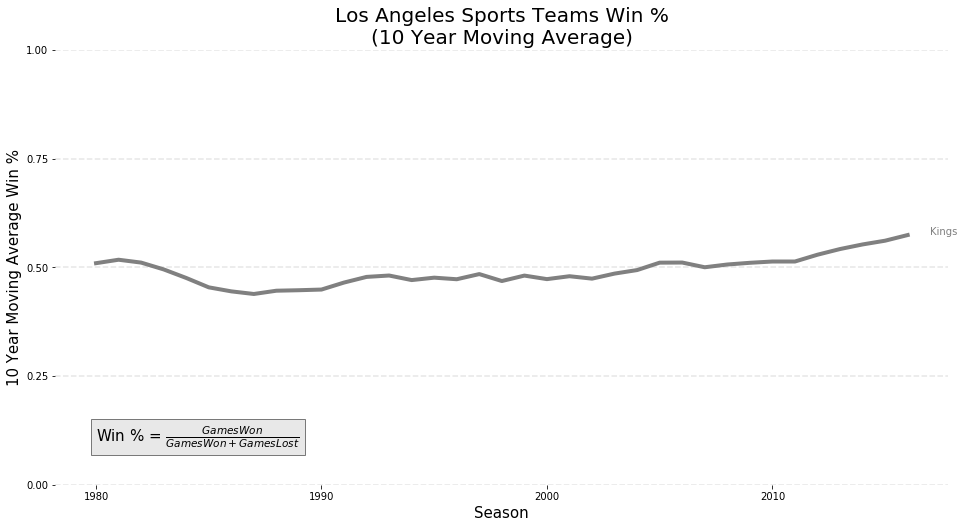

In [9]:
import matplotlib.pyplot as plt
import numpy as np

#----------------
# Variables
# (Start)
#----------------

graph_color = 'grey'

#----------------
# Variables
# (End)
#----------------

# Create new figure
fig_lakers = plt.figure(figsize = (16,8))
ax = fig_lakers.add_subplot(111)

# TODO
#
# -Set title
# -Set x label
# -Set y lable
# -Set x-axis to be the whole data but only show 10 year intervals
# -Set y-axis for 0.0 to 1.0 but have dotted lines from 0.0, 0.25, 0.75, 1.0 BUT only use the highest that contain data.
# -Set thick lines.
# -Set dotted lines at y-axis intervals 
# -Set annotations for names of team next to plot lines
# -Set annotations for win%
# Remove plot box
# Change the name of the figure to be generic for all teams and the save image.



# Title
plt.title('Los Angeles Sports Teams Win %'
           '\n(10 Year Moving Average)',
           fontsize=20 )

# Labels for x and y axes
plt.xlabel( 'Season',
             fontsize=15 )
plt.ylabel( '10 Year Moving Average Win %',
            fontsize=15 )

# Create graph
plot_lakers = plt.plot( df_kings_cleaned['Season'], 
                        df_kings_cleaned['Rolling_Mean'],
                        c=graph_color,
                        label='Lakers')

# Set limit on x-axis
#ax.set_xlim([datetime.date(2016, 1, 1), datetime.date(2016, 12, 31)])
ax.set_ylim(0.0, 0.85)

# Set line thickness and style (like dotted)
# https://matplotlib.org/examples/pylab_examples/set_and_get.html
# plt.setp(plot_lakers, 
#          linestyle='--')
plt.setp(plot_lakers, 
         linewidth=4)

# https://stackoverflow.com/questions/24943991/matplotlib-change-grid-interval-and-specify-tick-labels
#
# Set x-axis to be the whole data but only show 10 year intervals
x_major_ticks = np.arange(1980, 2020, 10)
#x_minor_ticks = np.arange(1980, 2020, 1)                                               
#
ax.set_xticks(x_major_ticks)                                                       
# ax.set_xticks(x_minor_ticks, minor=True)   
#
# Set y-axis for 0.0 to 1.0 but have dotted lines from 0.0, 0.25, 0.75, 1.0 BUT only use the highest that contain data.
y_major_ticks = np.arange(0.0, 1.1, 0.25)
#
# Slice to exclude the first and last entry.
#y_major_ticks = y_major_ticks[:-1]
ax.set_yticks(y_major_ticks)

# Draw horizontal lines
for num in y_major_ticks:
    plt.axhline(y = num,
                linestyle = '--',
                color = 'grey',
                alpha = 0.2 )

# Text for team names.
# Setting up equations in matplotlib text.
# https://matplotlib.org/users/mathtext.html
#team_name = 'Lakers'
x_pos = 2017
y_pos = df_kings_cleaned['Rolling_Mean'].iloc[-1]
team_color = graph_color
font_size = 10
plt.text(x_pos,
         y_pos,
         team_name,
         color = team_color,
         fontsize = font_size)


# Legend
plt.text(1980,
         0.1,
         #'Win % = Games Won\(Games Won + Games Lost)',
         #r'$\frac{5 - \frac{1}{x}}{4}$',
         r'Win % = $\frac{Games Won}{Games Won + Games Lost}$',
         fontsize = 15,
         bbox={'facecolor':'lightgrey', 'alpha':0.5, 'pad':5})


# Remove axis
#plt.axis('off')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the graph.
plt.show()


### Save graph to .png

In [10]:
# https://stackoverflow.com/questions/9012487/matplotlib-pyplot-savefig-outputs-blank-image

# plt.show()  creates a new figure.
# Use the figure captured when created.
#plt.savefig('Los_Angeles_Sports_Teams_Win_Percentage.png')
file_name = team_name +'_win_percentage'

# For some reason, matplotlib saves the image name with upper case as the first letter
# even if it is lowercase.
fig_lakers.savefig( file_name +'.png' )